# Machine Learning Immediate Recurrence of Atrial Fibrillation (IRAF) Susceptibility

Immediate Recurrence of Atrial Fibrillation (IRAF) occurs after synchronized cardioversion with a prevalence of 5-26%. [[1]] Recurrence decreases cardioversion efficacy and puts patients through the unnecessary risk of unsuccessful cardioversion. Better knowledge of patient susceptibility factors will allow clinicians to pre-treat these patients to reduce IRAF incidence. This project aims to shed more light on IRAF susceptibility factors through analysis of a cardioversion database.

[1]: https://deepblue.lib.umich.edu/bitstream/handle/2027.42/72654/j.1540-8167.2003.02415.x.pdf?sequence=1&isAllowed=y

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Install Missing Packages
# import sys
# !conda install --yes --prefix {sys.prefix} sklearn xgboost eli5 shap

In [3]:
data_file = '../ml-iraf-data/cvdb_v1_sanp.xls'
cvdb = pd.read_excel(data_file, sheet_name = 1)

In [4]:
print(list(cvdb))

['seqno', 'ep_date', 'expiration_date SSDI 051904', 'FU date SSDI 051904', 'Status SSDI 051904', 'ep_date.1', 'FUDays SSDI 0504', 'echo_date1', 'test_type', 'timing', 'primary_rhythm', 'study_quality', 'left_atrium_cm', 'lvid_diastolic', 'lvid_systolic', 'eject_fraction', 'la_cavity_area_sys', 'la_cavity_area_dia', 'la_cavity_size_x', 'la_cavity_size_y', 'la_cavity_size_z', 'lv_cavity_dilation_size', 'lv_test_timing', 'lv_systolic_function', 'lv_diastolic_filling_baseline', 'rv_cavity_dilation_size', 'test_timing', 'rv_systolic_function', 'rv_diastolic_function', 'mitral_regurge', 'tricuspid_regurge', 'MR1Code', 'TR1Code', 'AR1Code', 'rvsp', 'aortic_regurge', 'pulmonic_regurge', 'echo_date2', 'test_type.1', 'timing.1', 'primary_rhythm.1', 'study_quality.1', 'left_atrium_cm.1', 'lvid_diastolic.1', 'lvid_systolic.1', 'eject_fraction.1', 'la_cavity_area_sys.1', 'la_cavity_area_dia.1', 'la_cavity_size_x.1', 'la_cavity_size_y.1', 'la_cavity_size_z.1', 'lv_cavity_dilation_size.1', 'lv_test_t

In [5]:
print(cvdb.shape)

(6849, 255)


In [6]:
print(pd.unique(cvdb['CV success']))

['SUCCESSFUL' 'UNSUCCESSFUL' 'TRANSIENTLY SUCCESSFUL']


In [7]:
sum(cvdb['CV success'] == 'TRANSIENTLY SUCCESSFUL')/cvdb.shape[0]

0.06176084099868594

In [8]:
# One-hot encoding of CV success
from sklearn import preprocessing
import sklearn.pipeline

categories = pd.unique(cvdb['CV success'])
encoder = preprocessing.OneHotEncoder(handle_unknown='ignore', sparse=False)
key_fit = encoder.fit_transform(pd.DataFrame(categories))
key = pd.DataFrame(key_fit, columns = categories)
cv_success = pd.DataFrame(encoder.transform(cvdb.loc[:,['CV success']]), columns = categories[np.argmax(key_fit, axis=1)])
cv_trans = cv_success['TRANSIENTLY SUCCESSFUL']
cv_trans.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: TRANSIENTLY SUCCESSFUL, dtype: float64

### IRAF + Medications 

In [9]:
cvdb_meds = cvdb.loc[:,'Amiodarone':'Sotalol'].copy()
print(list(cvdb_meds))

['Amiodarone', 'Beta Blocker', 'Ca+ channel blocker', 'Digoxin', 'Disopyramide', 'Dofetelide', 'Fentanyl', 'Flecainide', 'Lidocaine', 'Mexiletine', 'Moricizine', 'None', 'Phenytoin', 'Procainamide', 'Propafenone', 'Quinidine', 'Sotalol']


#### Setting up Train and Test Sets

In [10]:
train_test_split = 0.8

In [11]:
from sklearn import model_selection

cvdb_meds_train, cvdb_meds_test, cv_trans_train, cv_trans_test = model_selection.train_test_split(cvdb_meds, cv_trans, train_size=train_test_split, test_size=1-train_test_split)
cvdb_meds_train, cvdb_meds_valid, cv_trans_train, cv_trans_valid = model_selection.train_test_split(cvdb_meds_train, cv_trans_train, train_size=train_test_split, test_size=1-train_test_split)

#### Creating XGBoost Model

In [43]:
from xgboost import XGBRegressor

xgboost_model = XGBRegressor()
xgboost_model.fit(cvdb_meds_train, cv_trans_train)
# xgboost_model = XGBRegressor(n_estimators=1500)
# xgboost_model.fit(cvdb_meds_train, cv_trans_train, early_stopping_rounds=5, eval_set=[(cvdb_meds_valid, cv_trans_valid)])

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [44]:
from sklearn import metrics

predictions = xgboost_model.predict(cvdb_meds_valid)
mae = metrics.mean_absolute_error(predictions, cv_trans_valid)
r_predictions = predictions.round()
model_accuracy = metrics.accuracy_score(cv_trans_valid, r_predictions)

print('MAE = ',mae)
print('Model Accuracy = ', model_accuracy)

MAE =  0.11148125819698737
Model Accuracy =  0.9416058394160584


In [45]:
predictions = xgboost_model.predict(cvdb_meds_test)
mae = metrics.mean_absolute_error(predictions, cv_trans_test)
r_predictions = predictions.round()
model_accuracy = metrics.accuracy_score(cv_trans_test, r_predictions)

print('MAE = ',mae)
print('Model Accuracy = ', model_accuracy)

MAE =  0.11488041323031822
Model Accuracy =  0.9394160583941605


In [46]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(xgboost_model).fit(cvdb_meds_valid, cv_trans_valid)
eli5.show_weights(perm, feature_names = cvdb_meds_valid.columns.tolist())

Weight,Feature
0.0910 ± 0.0273,Amiodarone
0.0376 ± 0.0452,Flecainide
0.0351 ± 0.0342,Sotalol
0.0220 ± 0.0207,Dofetelide
0.0180 ± 0.0169,Digoxin
0.0108 ± 0.0078,Beta Blocker
0.0098 ± 0.0218,Ca+ channel blocker
0.0063 ± 0.0155,Disopyramide
0.0050 ± 0.0083,Propafenone
0.0031 ± 0.0340,None


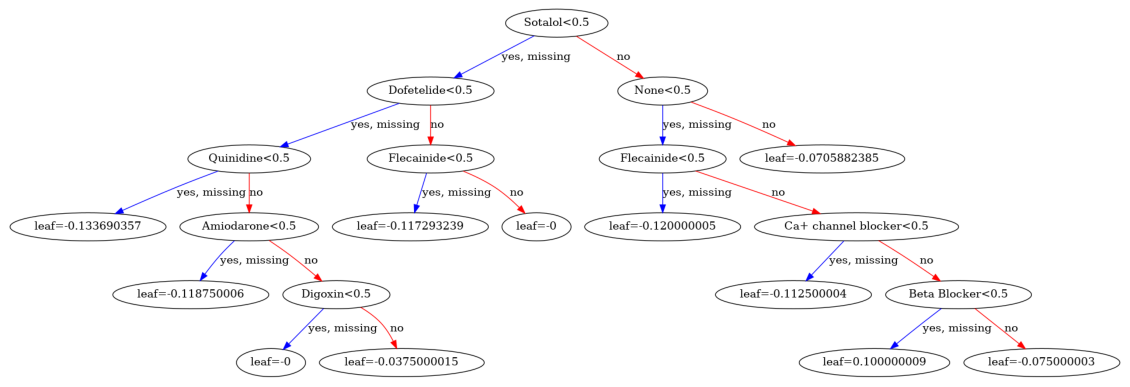

In [51]:
from xgboost import plot_tree
import matplotlib.pyplot as plt

plot_tree(xgboost_model)
fig = plt.gcf()
fig.set_size_inches(20,15)
plt.show()

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


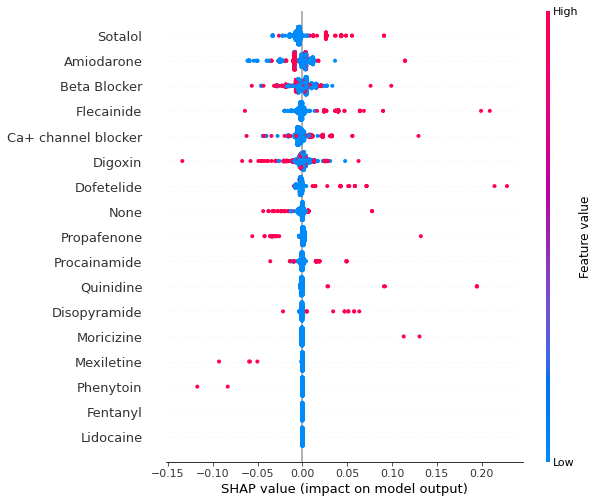

In [58]:
import shap

explainer = shap.TreeExplainer(xgboost_model)
shap_values = explainer.shap_values(cvdb_meds_valid)
shap.summary_plot(shap_values, cvdb_meds_valid)

#### Deep Learning

In [68]:
meds_dfs = [cvdb_meds_train, cvdb_meds_valid, cvdb_meds_test]
for df in meds_dfs:
    df.columns = df.columns.str.replace(' ', '_')
    df.columns = df.columns.str.replace('+', '')
list(cvdb_meds_train)[0:5]

['Amiodarone', 'Beta_Blocker', 'Ca_channel_blocker', 'Digoxin', 'Disopyramide']

In [69]:
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers

In [70]:
def df_to_dataset(dataframe, labels, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = labels.copy()
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [71]:
batch_size = 10
train_ds = df_to_dataset(cvdb_meds_train, cv_trans_train, batch_size=batch_size)
val_ds = df_to_dataset(cvdb_meds_valid, cv_trans_valid, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(cvdb_meds_test, cv_trans_test, shuffle=False, batch_size=batch_size)

In [72]:
for feature_batch, label_batch in train_ds.take(1):
    print('Every feature:', list(feature_batch.keys()))
    print('A batch of ages:', feature_batch['Amiodarone'])
    print('A batch of targets:', label_batch )

Every feature: ['Amiodarone', 'Beta_Blocker', 'Ca_channel_blocker', 'Digoxin', 'Disopyramide', 'Dofetelide', 'Fentanyl', 'Flecainide', 'Lidocaine', 'Mexiletine', 'Moricizine', 'None', 'Phenytoin', 'Procainamide', 'Propafenone', 'Quinidine', 'Sotalol']
A batch of ages: tf.Tensor([0 0 0 0 0 0 0 0 0 0], shape=(10,), dtype=int64)
A batch of targets: tf.Tensor([0. 1. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float64)


In [73]:
feature_columns = []
for med in list(cvdb_meds_train):
    med_feature = feature_column.categorical_column_with_identity(med, num_buckets=1)
    med_feature_oh = feature_column.indicator_column(med_feature)
    feature_columns.append(med_feature_oh) 

In [74]:
# example_batch = next(iter(train_ds))[0]
# def demo(feature_column):
#     feature_layer = layers.DenseFeatures(feature_column)
#     print(feature_layer(example_batch).numpy())
# demo(feature_columns[0])

In [75]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [76]:
batch_size = 32
train_ds = df_to_dataset(cvdb_meds_train, cv_trans_train, batch_size=batch_size)
val_ds = df_to_dataset(cvdb_meds_valid, cv_trans_valid, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(cvdb_meds_test, cv_trans_test, shuffle=False, batch_size=batch_size)

In [77]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_ds,
          validation_data=val_ds,
          epochs=5)

Epoch 1/5
137/137 [==============================] - 1s 7ms/step - loss: 0.2455 - accuracy: 0.9379 - val_loss: 0.2433 - val_accuracy: 0.9325
Epoch 2/5
137/137 [==============================] - 0s 3ms/step - loss: 0.2313 - accuracy: 0.9379 - val_loss: 0.2420 - val_accuracy: 0.9325
Epoch 3/5
137/137 [==============================] - 0s 3ms/step - loss: 0.2306 - accuracy: 0.9379 - val_loss: 0.2423 - val_accuracy: 0.9325
Epoch 4/5
137/137 [==============================] - 0s 3ms/step - loss: 0.2311 - accuracy: 0.9379 - val_loss: 0.2436 - val_accuracy: 0.9325
Epoch 5/5
137/137 [==============================] - 0s 3ms/step - loss: 0.2315 - accuracy: 0.9379 - val_loss: 0.2406 - val_accuracy: 0.9325


In [78]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

43/43 [==============================] - 0s 2ms/step - loss: 0.2137 - accuracy: 0.9438
Accuracy 0.9437956213951111
